# Agent: Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 Agent를 만든느 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- [Local Deep Researcher](https://github.com/langchain-ai/local-deep-researcher)



---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [85]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse already exists
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [86]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [87]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [88]:
# connection test
langfuse_handler.auth_check()

True

## 5. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [89]:
from langchain_aws import ChatBedrockConverse

model_id = "us.amazon.nova-micro-v1:0" # 1.06 초
# model_id = "us.amazon.nova-lite-v1:0" # 1.58 초
# model_id = "us.amazon.nova-pro-v1:0" # 3.2 초
# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0" # 5.37 초
# model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0" # 6.21 초

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7f53c6bcfee0>, model_id='us.amazon.nova-micro-v1:0', temperature=0.0, region_name='us-east-1', provider='amazon', supports_tool_choice_values=['auto'])

## 6. Grpah 정의 하기

In [90]:
from typing import Literal
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)    

### State 정의

In [91]:
# Built-in MessagesState 사용하기
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


### Node 및 분기  함수 정의

In [92]:
# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs. when answering, use Korean"
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

### 그래프 구조 만들기

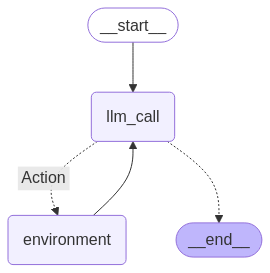

In [93]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Graph 호출

In [94]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4 and multiply 2")]
messages = agent.invoke({"messages": messages},
    config={
            "callbacks": [langfuse_handler],
        }
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [95]:
messages

{'messages': [HumanMessage(content='Add 3 and 4 and multiply 2', additional_kwargs={}, response_metadata={}, id='aae6c957-1b58-4613-9449-84b704028e45'),
  AIMessage(content=[{'type': 'text', 'text': '<thinking> The user wants to add 3 and 4 first, and then multiply the result by 2. I will first use the `add` tool to add 3 and 4, and then use the `multiply` tool to multiply the result by 2. </thinking>\n'}, {'type': 'tool_use', 'name': 'add', 'input': {'a': 3, 'b': 4}, 'id': 'tooluse_9QLsoFMPSeSwKp-keKU4lg'}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 7, 'b': 2}, 'id': 'tooluse_8wcB8Qy8QF26pyaJBLcXuw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'cb67bd97-6179-4d90-a2c2-c768b734fd12', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 23 Mar 2025 02:08:22 GMT', 'content-type': 'application/json', 'content-length': '583', 'connection': 'keep-alive', 'x-amzn-requestid': 'cb67bd97-6179-4d90-a2c2-c768b734fd12'}, 'RetryAttempts': 0}, 'stopReaso

### State 값 흐름에 따라 출력

In [96]:
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

Add 3 and 4 and multiply 2
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> The user wants to add 3 and 4 first, and then multiply the result by 2. I will first use the `add` tool to add 3 and 4, and then use the `multiply` tool to multiply the result by 2. </thinking>\n'}, {'type': 'tool_use', 'name': 'add', 'input': {'a': 3, 'b': 4}, 'id': 'tooluse_9QLsoFMPSeSwKp-keKU4lg'}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 7, 'b': 2}, 'id': 'tooluse_8wcB8Qy8QF26pyaJBLcXuw'}]
Tool Calls:
  add (tooluse_9QLsoFMPSeSwKp-keKU4lg)
 Call ID: tooluse_9QLsoFMPSeSwKp-keKU4lg
  Args:
    a: 3
    b: 4
  multiply (tooluse_8wcB8Qy8QF26pyaJBLcXuw)
 Call ID: tooluse_8wcB8Qy8QF26pyaJBLcXuw
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

7
================================= Tool Message

## 7. Langfuse Tracing Output
![agent_multi_tools.png](img/agent_multi_tools.png)